# Bozza Random forest

Random forest fatta così non ha un cazzo di senso.
Avrà senso aggiungere la Z insieme ai dati e fare un unico grande dataset.
Dopodiche si può fare PCA, per scartare le componenti a due a due mega correlate, visto che rappresenteranno più o meno la stessa grandezza fisica.
Così possiamo ridurre il numero di features e rimane computaizonemlmente meno intensivo.

Altra cosa Mrem secondo me è una buona feature che racchiude varie cose, Dipende da Z, natal kick, m1, m2.

#### qui sopra non si è mai trattato di metallicità. qui sotto inserisco la metallicità in ogni dataset e li unisco tutti e rifaccio l'algoritmo

In [1]:
import pandas as pd
import os


heade = ['M1', 'M2', 'S1', 'S2', 't_pair', 't_elapsed', 'Mrem', 'Srem', 'esca_v', 'Mcluster', 'gen']

path_data = './data/'
dyn = '/Dyn/' # Direi che così è facilmente customizzabile per come ogni autistic* si è sistemato i files.
cols = [1,2,3,4,9,13,15,16,17,25,27]
print(len(cols), len(heade))

11 11


In [2]:
def extractor(path_data, cluster):
    data = pd.DataFrame()
    wichcluster = os.listdir(path_data)
    #print(wichcluster)
    if cluster == 'gc':
        cluster = wichcluster[2]
    if cluster == 'nsc':
        cluster = wichcluster[1]
    if cluster == 'ysc':
        cluster = wichcluster[0]
    for i in os.listdir(path_data + cluster + dyn):
        #print(i)
        name = path_data + cluster + dyn + str(i) + '/nth_generation.txt'
        #print(name)
        dataZ=pd.read_csv(name, delimiter=' ', skiprows=1, usecols=cols, names=heade)#, names=heade)
        #dataZ.drop(dataZ.columns[[0, 5, 6, 7, 8, 10, 11, 12, 14, 18, 19, 20, 21, 22, 23, 24, 26]], axis=1, inplace=True)
        #dataZ.columns = heade
        dataZ['Z'] = float(i)
        data = pd.concat([data, dataZ])
    return data

In [3]:
dgc = extractor(path_data, 'ysc')

In [4]:
df = dgc.sample(frac=0.1)
print(df.dtypes)

M1           float64
M2           float64
S1           float64
S2           float64
t_pair       float64
t_elapsed    float64
Mrem         float64
Srem         float64
esca_v       float64
Mcluster     float64
gen            int64
Z            float64
dtype: object


#### PCA

In [5]:
def normer_col(df,i):
    media = df[i].mean()
    std = df[i].std()
    coso = (df[i] - media)/std
    return coso

0.7445131365441531


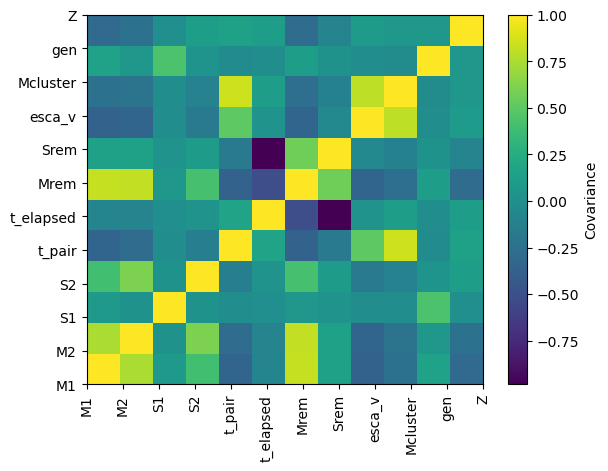

In [6]:
import matplotlib.pyplot as plt
import numpy as np
heade = list(df.columns)
matrix = np.zeros((len(heade), len(heade)))
for i in heade:
    a = heade.index(i)
    inorm = normer_col(df,i)
    for j in heade:
        #if i !=j:
        b = heade.index(j)
        jnorm = normer_col(df,j)
        #print(i,j)            
        c = np.cov(inorm, jnorm)[0,1]
        if i=='M1' and j =='M2':
            print(c)
        #print(np.cov(inorm, jnorm)[0,1])
        matrix[b,a] = c
            
x, y = np.meshgrid(np.arange(matrix.shape[1]), np.arange(matrix.shape[0]))
x = x.flatten()
y = y.flatten()
values = matrix.flatten()

ticks = np.linspace(-0.5,11.5,1)
# Create a 2D histogram
plt.hist2d(x,y, weights=values, bins=(matrix.shape[1], matrix.shape[0]), cmap='viridis')
plt.colorbar(label='Covariance')
plt.xticks(ticks=np.arange(len(heade)), labels=heade, rotation=90)  # Tick for each bin, labeled with `heade`
plt.yticks(ticks=np.arange(len(heade)), labels=heade)
#plt.ylabel(heade.index())
plt.show()


Ora , siccome alta correlazione significa che le quantità indicano più o meno la stessa grandezza e viceversa bassissima sono l'una l'inverso dell'altra, seleziono le features che hanno una correlazione compresa tra abs(0.6).
Tipo si vede che M1 e M2 hanno la stessa identica relaziono con praticamente tutte le quantità, E sono fortemente correlate con Mrem, per cui si potrebbe ridurre le features tralasciando M2 e M1 e tenendo Mrem.  S1 ha una correlazione nulla con ciascuna feature, per cui non sembra eliminabile; stessa cosa per S2. 
Per Z vediamo che corrisponde alla teoria, è inversamente proporzionale alle masse e alla massa del remnant. Il t_pair, tempo di accoppiamento è giustamente inversamente proporzionale alle masse.
T_elapsed non lo so perchè sia fortemente inv-correlato con lo spin del remnant. Escape velocity è inversamente correlato alle singole masse e direttamente alla massa totale. La generazione del buco nero è debolmente correlata a tutto, tranne che allo spin. NOn so a livello fisico cosa faccia lo spin però.

In [7]:
# Siccome M1,M2 sono estremamnte correlate magari prendere il rapporto tra le due potrebbe essere interessante
df['q'] = df['M2']/df['M1']
df = df.drop(columns=['M1', 'M2'])


In [8]:
def normer_col(df,i):
    media = df[i].mean()
    std = df[i].std()
    coso = (df[i] - media)/std
    return coso

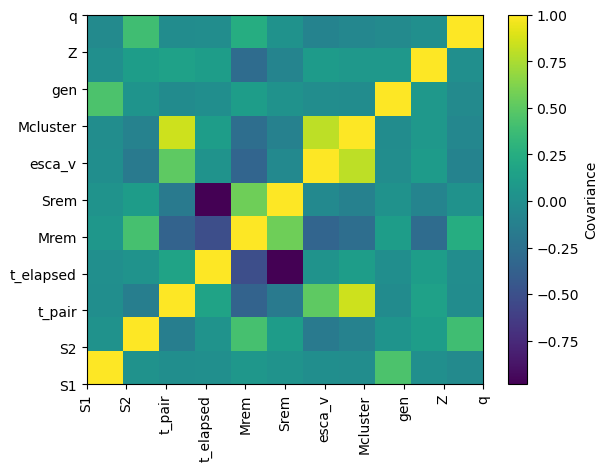

In [9]:
import matplotlib.pyplot as plt
import numpy as np
heade = list(df.columns)
matrix = np.zeros((len(heade), len(heade)))
for i in heade:
    a = heade.index(i)
    inorm = normer_col(df,i)
    for j in heade:
        #if i !=j:
        b = heade.index(j)
        jnorm = normer_col(df,j)
        #print(i,j)            
        c = np.cov(inorm, jnorm)[0,1]
        if i=='M1' and j =='M2':
            print(c)
        #print(np.cov(inorm, jnorm)[0,1])
        matrix[b,a] = c
            
x, y = np.meshgrid(np.arange(matrix.shape[1]), np.arange(matrix.shape[0]))
x = x.flatten()
y = y.flatten()
values = matrix.flatten()

ticks = np.linspace(-0.5,11.5,1)
# Create a 2D histogram
plt.hist2d(x,y, weights=values, bins=(matrix.shape[1], matrix.shape[0]), cmap='viridis')
plt.colorbar(label='Covariance')
plt.xticks(ticks=np.arange(len(heade)), labels=heade, rotation=90)  # Tick for each bin, labeled with `heade`
plt.yticks(ticks=np.arange(len(heade)), labels=heade)
#plt.ylabel(heade.index())
plt.show()


#### PCA

### ML 

##### Ho pensato che feature che sono importanti da usare come target sono la massa del buco nero, quale caratteristica è più identificativa di un buco nero del resto, ma anche la feature GEN, generazione del buco nero. ci interessa anche questa.

['S1', 'S2', 't_pair', 't_elapsed', 'Mrem', 'Srem', 'esca_v', 'Mcluster', 'gen', 'Z', 'q']             S1        S2     t_pair      t_elapsed        Mrem      Srem  \
1036  0.695788  0.093147   6.346273      29.726712   99.094383  0.814194   
461   0.746451  0.088366   9.826001    2011.395037   71.219661  0.852832   
184   0.718693  0.279063  71.965615  136000.000000    0.000000  0.000000   
333   0.730508  0.715484   7.209812     391.308790  120.247340  0.889099   
51    0.712860  0.752250   6.174514     752.071398  111.717696  0.889428   

         esca_v       Mcluster  gen       Z         q  
1036  19.674902   57994.122023    2  0.0002  0.878891  
461   25.224766   98118.589999    2  0.0016  0.537217  
184   35.684024  324405.402474    2  0.0080  0.554161  
333   20.410047   71838.534639    2  0.0040  0.921913  
51    18.887889   58534.913866    2  0.0080  0.824324  
Mean Absolute Error (MAE): 21.459
Mean Squared Error (MSE): 721.366
R² Score: 0.647


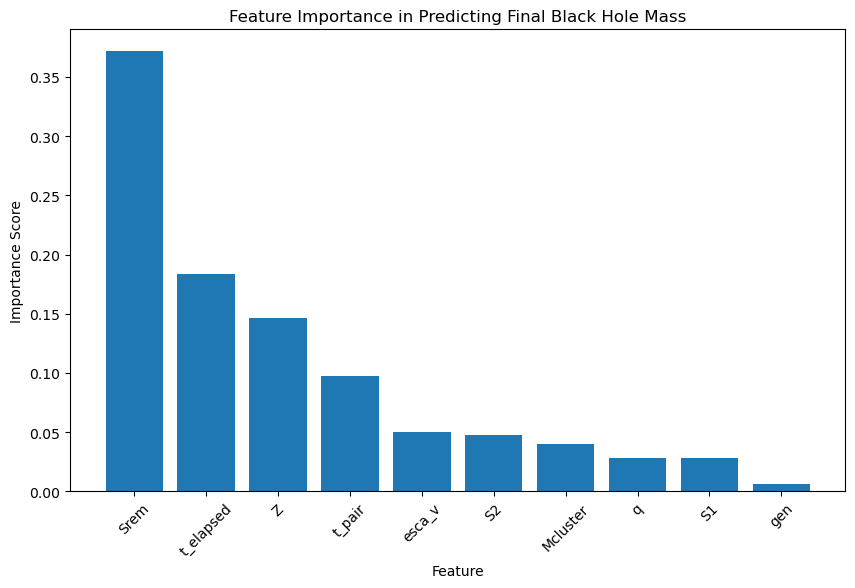

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Assign column names
columns = list(df.columns)
# Display data summary
print(columns, df.head())

X = df.drop(columns='Mrem')
y = df['Mrem']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation results
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R² Score: {r2:.3f}")

import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_idx], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in sorted_idx], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance in Predicting Final Black Hole Mass")
plt.show()

In [ ]:
## Interessante. Lo spin si riferisce a una componente dello spin che è perpendicolare al piano orbitale del sistema. Di conseguenza alto spin comporta una o più
# perturbazioni di una certa entità, ergo, interazioni dinamiche con altri oggetti del cluster. E' chiaro che maggiori sono le interazioni maggiori sono le possibilità di merge
# Stessa cosa è T-elapsed. CHè è il tempo che passa dalla formazione dei genitori di prima generazione al BH di n-esima generazione. Più tempo passa più sono probabili interazioni 
#dinamiche e merge gerarchici.
# Z sappiamo bene che è parte integrante della funzione di massa dei buchi neri.
# Escape velocity può essere importante come indicatore di permamenza nel cluster.

['S1', 'S2', 't_pair', 't_elapsed', 'Mrem', 'Srem', 'esca_v', 'Mcluster', 'gen', 'Z', 'q']             S1        S2     t_pair      t_elapsed        Mrem      Srem  \
1036  0.695788  0.093147   6.346273      29.726712   99.094383  0.814194   
461   0.746451  0.088366   9.826001    2011.395037   71.219661  0.852832   
184   0.718693  0.279063  71.965615  136000.000000    0.000000  0.000000   
333   0.730508  0.715484   7.209812     391.308790  120.247340  0.889099   
51    0.712860  0.752250   6.174514     752.071398  111.717696  0.889428   

         esca_v       Mcluster  gen       Z         q  
1036  19.674902   57994.122023    2  0.0002  0.878891  
461   25.224766   98118.589999    2  0.0016  0.537217  
184   35.684024  324405.402474    2  0.0080  0.554161  
333   20.410047   71838.534639    2  0.0040  0.921913  
51    18.887889   58534.913866    2  0.0080  0.824324  
Mean Absolute Error (MAE): 0.000
Mean Squared Error (MSE): 0.000
R² Score: 1.000


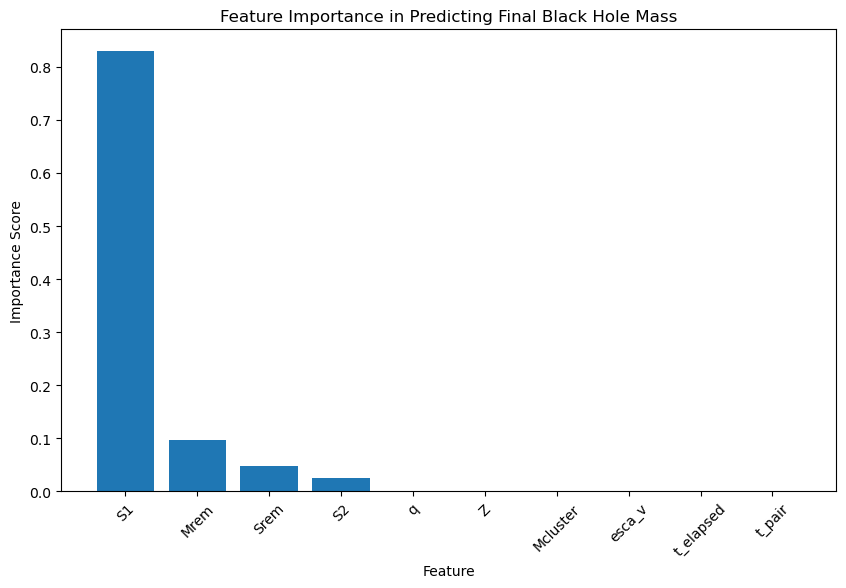

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Assign column names
columns = list(df.columns)
# Display data summary
print(columns, df.head())

X = df.drop(columns='gen')
y = df['gen']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation results
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R² Score: {r2:.3f}")

import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_idx], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in sorted_idx], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance in Predicting The nth-generation of the BH")
plt.show()

In [ ]:
## Come prima La componente di spin perpendicolare al piano orbitale è forte indicatore di interazioni con altri elementi del cluster. è più importante S1 rispetto a S2
# probabilmente perchè perturbare il corpo primario, non lo so.
# Mrem è chiaro invece dai.